# Multi-view reconstruction and Meshing

## 1. Prerequisites

### 1.1 Load data

In [5]:
from openalea.phenomenal.data.plant_1 import (
    plant_1_images,
    plant_1_images_binarize,
    plant_1_calibration_camera_side,
    plant_1_calibration_camera_top)

images_raw = plant_1_images()
images_bin = plant_1_images_binarize()
calibration_side = plant_1_calibration_camera_side()
calibration_top = plant_1_calibration_camera_top()

<IPython.core.display.Javascript object>


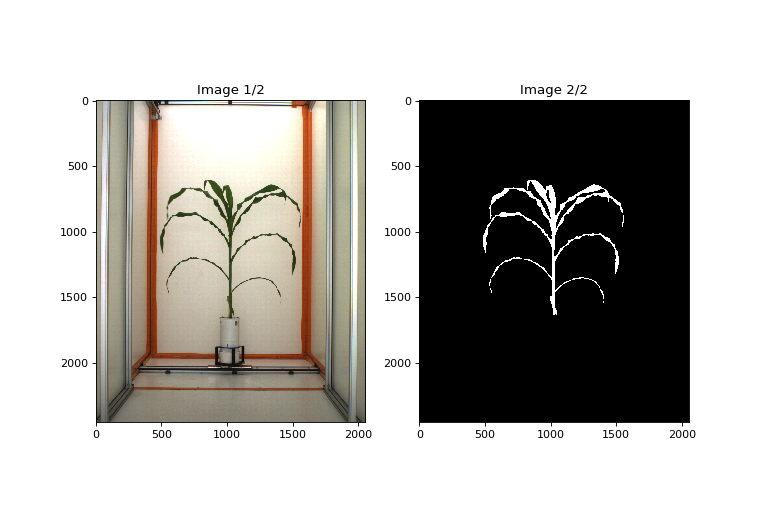

In [6]:
%matplotlib notebook

from openalea.phenomenal.display.image import show_images

angle = 120
show_images([images_raw['side'][angle], images_bin[angle]])

## 2. Multi-view reconstruction

### 2.1 Associate images and projection function

In [7]:
from openalea.phenomenal.object import ImageView

refs_angle_list = [120]

# Select images
image_views = list()
for angle in range(0, 360, 30):
    projection = calibration_side.get_projection(angle)
    
    ref = False
    if angle in refs_angle_list:
        ref = True
    
    image_views.append(ImageView(images_bin[angle], projection, inclusive=False, ref=ref))

projection = calibration_top.get_projection(0)
image_views.append(ImageView(images_bin[-1], projection, inclusive=True))

### 2.2 Do multi-view reconstruction

In [8]:
from openalea.phenomenal.object import VoxelGrid
from openalea.phenomenal.multi_view_reconstruction import reconstruction_3d

voxels_size = 8
error_tolerance = 1

vg = reconstruction_3d(image_views, 
                       voxels_size=voxels_size, 
                       error_tolerance=error_tolerance, 
                       verbose=True)

Iteration 1 / 9 : 8
Iteration 2 / 9 : 64
Iteration 3 / 9 : 512
Iteration 4 / 9 : 4096
Iteration 5 / 9 : 400
Iteration 6 / 9 : 1392
Iteration 7 / 9 : 4216
Iteration 8 / 9 : 13776
Iteration 9 / 9 : 55560


### 2.4 Viewing

In [9]:
from openalea.phenomenal.display.notebook import show_voxel_grid

show_voxel_grid(vg)

A Jupyter Widget

# 3.Meshing

In [10]:
from openalea.phenomenal.mesh import meshing
from openalea.phenomenal.display.notebook import show_mesh

In [11]:
image_3d = vg.to_image_3d()

vertices, faces = meshing(image_3d,
                          reduction=1,
                          smoothing_iteration=10,
                          verbose=True)

print("Number of vertices : {nb_vertices}".format(nb_vertices=len(vertices)))
print("Number of faces : {nb_faces}".format(nb_faces=len(faces)))

Marching cubes : 
	Iso value :1.0

	There are 16755 points.
	There are 33916 polygons.
Smoothing : 
	Feature angle :120.0
	Number of iteration :10
	Pass band : 0.01

Number of vertices : 16755
Number of faces : 33916


In [12]:
show_mesh(vertices, faces)

A Jupyter Widget